In [1]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff

In [2]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [3]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
#pls_par = np.array([-580., 10., -10., 40., 120., 15.]) 
pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,20)
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,20)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [4]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 4.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)



#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


In [5]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [6]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [7]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [8]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [9]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [10]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [11]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad

In [12]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [13]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-480. -100.  -80.   20.   50.   25.]
[-478.60442667 -105.56171507  -69.64541697   10.           51.52901869
   21.59192015]


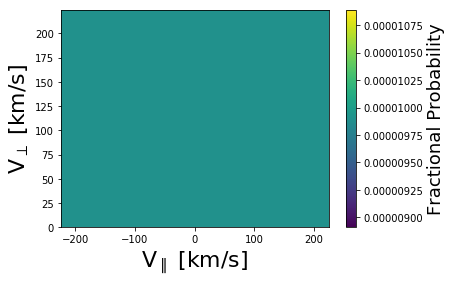

In [14]:
#create grid to call predictions
#pred_grid = np.zeros(dis_vdf_bad_guess['pgrid'].shape)+1
#change initial prediction 
pred_grid /= np.sum(pred_grid)
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [15]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.

start_loop = time.time()
#removed to test improving fit
for i in range(1000):
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,
                                                                            dis_vdf_bad,cont,pred_grid,
                                                                            improved=improved,ip=ip,
                                                                            iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=per_err,samp=samp)
    
    if improved:
        #calculate peak at ip,iq values
        a = np.sum(pred_grid)/float(pred_grid.size)
        pred_grid += a*np.exp(- ((dis_vdf_bad_guess['pgrid']-ip)/(100.*per_err))**2./2.
                              - ((dis_vdf_bad_guess['qgrid']-iq)/(100.*per_err))**2./2.)
        pred_grid /= np.sum(pred_grid)
        print(per_err) 
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))

end_loop = time.time()
print('Loop time {0:1.1f}'.format(end_loop-start_loop))

(0.0, 0.0, array([ 0.5,  0.5]))
0.1
Total error for iteration 0 is 1.418e+01%
(0.0, 0.0, array([ 0.,  1.]))
Total error for iteration 1 is 1.418e+01%
(-5.92072170266436, 0.5199275128304547, array([ 0.5,  0.5]))
Total error for iteration 2 is 1.418e+01%
(38.393202250021034, 198.0, array([ 0.5,  0.5]))
Total error for iteration 3 is 1.418e+01%
(-45.606797749978966, 0.0, array([ 0.5,  0.5]))
Total error for iteration 4 is 1.418e+01%
(-206.60679774997897, 191.0, array([ 0.5,  0.5]))
Total error for iteration 5 is 1.418e+01%
(217.39320225002103, 182.0, array([ 0.5,  0.5]))
Total error for iteration 6 is 1.418e+01%
(117.39320225002103, 154.0, array([ 0.5,  0.5]))
Total error for iteration 7 is 1.418e+01%
(189.39320225002103, 218.0, array([ 0.5,  0.5]))
Total error for iteration 8 is 1.418e+01%
(-162.60679774997897, 52.0, array([ 0.5,  0.5]))
Total error for iteration 9 is 1.418e+01%
(-36.606797749978966, 145.0, array([ 0.5,  0.5]))
Total error for iteration 10 is 1.418e+01%
(144.393202250021

0.124482479342
Total error for iteration 87 is 1.159e+01%
(-8.103364509117393, 42.01938581320359, array([ 0.,  1.]))
0.115876698902
Total error for iteration 88 is 1.056e+01%
(-13.771110361176298, 37.418771150946995, array([ 0.,  1.]))
0.105626129117
Total error for iteration 89 is 9.717e+00%
(-12.848916367082111, 31.29731584670273, array([ 0.,  1.]))
0.0971708409976
Total error for iteration 90 is 9.007e+00%
(-11.110879510034557, 32.13932983425412, array([ 0.,  1.]))
Total error for iteration 91 is 9.007e+00%
(-7.501723818227104, 31.9776536262069, array([ 0.5,  0.5]))
Total error for iteration 92 is 9.007e+00%
(24.393202250021034, 105.0, array([ 0.,  1.]))
Total error for iteration 93 is 9.007e+00%
(-156.60679774997897, 0.0, array([ 0.,  1.]))
Total error for iteration 94 is 9.007e+00%
(182.39320225002103, 37.0, array([ 0.,  1.]))
Total error for iteration 95 is 9.007e+00%
(140.39320225002103, 75.0, array([ 0.,  1.]))
Total error for iteration 96 is 9.007e+00%
(162.39320225002103, 134

Total error for iteration 172 is 8.669e+00%
(103.39320225002103, 106.0, array([ 0.5,  0.5]))
Total error for iteration 173 is 8.669e+00%
(-5.606797749978966, 36.0, array([ 0.5,  0.5]))
Total error for iteration 174 is 8.669e+00%
(-24.606797749978966, 55.0, array([ 0.5,  0.5]))
Total error for iteration 175 is 8.669e+00%
(219.39320225002103, 72.0, array([ 0.5,  0.5]))
Total error for iteration 176 is 8.669e+00%
(-43.606797749978966, 205.0, array([ 0.5,  0.5]))
Total error for iteration 177 is 8.669e+00%
(-46.606797749978966, 140.0, array([ 0.5,  0.5]))
Total error for iteration 178 is 8.669e+00%
(-99.60679774997897, 167.0, array([ 0.5,  0.5]))
Total error for iteration 179 is 8.669e+00%
(1.3932022500210337, 25.0, array([ 0.5,  0.5]))
Total error for iteration 180 is 8.669e+00%
(54.393202250021034, 49.0, array([ 0.,  1.]))
Total error for iteration 181 is 8.669e+00%
(108.39320225002103, 20.0, array([ 0.,  1.]))
Total error for iteration 182 is 8.669e+00%
(85.39320225002103, 207.0, array(

Total error for iteration 258 is 8.483e+00%
(-182.60679774997897, 215.0, array([ 0.5,  0.5]))
Total error for iteration 259 is 8.483e+00%
(126.39320225002103, 105.0, array([ 1.,  0.]))
Total error for iteration 260 is 8.483e+00%
(-214.60679774997897, 37.0, array([ 0.5,  0.5]))
Total error for iteration 261 is 8.483e+00%
(204.39320225002103, 42.0, array([ 0.5,  0.5]))
Total error for iteration 262 is 8.483e+00%
(138.39320225002103, 155.0, array([ 0.5,  0.5]))
Total error for iteration 263 is 8.483e+00%
(92.39320225002103, 30.0, array([ 1.,  0.]))
Total error for iteration 264 is 8.483e+00%
(-20.606797749978966, 34.0, array([ 0.5,  0.5]))
Total error for iteration 265 is 8.483e+00%
(164.39320225002103, 108.0, array([ 0.5,  0.5]))
Total error for iteration 266 is 8.483e+00%
(-194.60679774997897, 81.0, array([ 0.,  1.]))
Total error for iteration 267 is 8.483e+00%
(190.39320225002103, 112.0, array([ 0.5,  0.5]))
Total error for iteration 268 is 8.483e+00%
(144.39320225002103, 136.0, array(

Total error for iteration 347 is 8.480e+00%
(7.393202250021034, 77.0, array([ 0.5,  0.5]))
Total error for iteration 348 is 8.480e+00%
(-198.60679774997897, 93.0, array([ 0.5,  0.5]))
Total error for iteration 349 is 8.480e+00%
(-8.606797749978966, 220.0, array([ 0.5,  0.5]))
Total error for iteration 350 is 8.480e+00%
(86.39320225002103, 41.0, array([ 0.5,  0.5]))
Total error for iteration 351 is 8.480e+00%
(-165.60679774997897, 98.0, array([ 0.,  1.]))
Total error for iteration 352 is 8.480e+00%
(187.39320225002103, 204.0, array([ 0.5,  0.5]))
Total error for iteration 353 is 8.480e+00%
(206.39320225002103, 15.0, array([ 0.,  1.]))
Total error for iteration 354 is 8.479e+00%
(-38.606797749978966, 81.0, array([ 0.,  1.]))
Total error for iteration 355 is 8.479e+00%
(-43.606797749978966, 128.0, array([ 0.5,  0.5]))
Total error for iteration 356 is 8.479e+00%
(-11.606797749978966, 35.0, array([ 0.5,  0.5]))
Total error for iteration 357 is 8.479e+00%
(-101.60679774997897, 161.0, array([

Total error for iteration 430 is 8.023e+00%
(17.393202250021034, 13.0, array([ 0.5,  0.5]))
Total error for iteration 431 is 8.023e+00%
(-47.606797749978966, 42.0, array([ 0.5,  0.5]))
Total error for iteration 432 is 8.023e+00%
(26.393202250021034, 153.0, array([ 0.5,  0.5]))
Total error for iteration 433 is 8.023e+00%
(-148.60679774997897, 208.0, array([ 0.5,  0.5]))
Total error for iteration 434 is 8.023e+00%
(-195.60679774997897, 123.0, array([ 0.5,  0.5]))
Total error for iteration 435 is 8.023e+00%
(-100.60679774997897, 74.0, array([ 1.,  0.]))
Total error for iteration 436 is 8.023e+00%
(131.39320225002103, 157.0, array([ 0.5,  0.5]))
Total error for iteration 437 is 8.023e+00%
(-36.606797749978966, 119.0, array([ 0.5,  0.5]))
Total error for iteration 438 is 8.023e+00%
(15.393202250021034, 46.0, array([ 0.5,  0.5]))
Total error for iteration 439 is 8.023e+00%
(-137.60679774997897, 44.0, array([ 0.5,  0.5]))
Total error for iteration 440 is 8.023e+00%
(-62.606797749978966, 60.0,

0.0798951526271
Total error for iteration 517 is 7.980e+00%
(37.393202250021034, 69.0, array([ 0.,  1.]))
0.0797962117292
Total error for iteration 518 is 7.974e+00%
(38.82400826830725, 67.95239177342401, array([ 0.,  1.]))
Total error for iteration 519 is 7.974e+00%
(42.86460906744532, 63.938758017935946, array([ 0.5,  0.5]))
Total error for iteration 520 is 7.974e+00%
(134.39320225002103, 183.0, array([ 0.5,  0.5]))
Total error for iteration 521 is 7.974e+00%
(13.393202250021034, 33.0, array([ 0.5,  0.5]))
Total error for iteration 522 is 7.974e+00%
(54.393202250021034, 68.0, array([ 1.,  0.]))
Total error for iteration 523 is 7.974e+00%
(-17.606797749978966, 52.0, array([ 0.5,  0.5]))
Total error for iteration 524 is 7.974e+00%
(65.39320225002103, 60.0, array([ 0.5,  0.5]))
Total error for iteration 525 is 7.974e+00%
(183.39320225002103, 104.0, array([ 0.5,  0.5]))
Total error for iteration 526 is 7.974e+00%
(-84.60679774997897, 219.0, array([ 0.5,  0.5]))
Total error for iteration 

Total error for iteration 605 is 7.970e+00%
(-168.60679774997897, 80.0, array([ 1.,  0.]))
Total error for iteration 606 is 7.970e+00%
(-220.60679774997897, 90.0, array([ 0.5,  0.5]))
Total error for iteration 607 is 7.970e+00%
(-187.60679774997897, 208.0, array([ 0.5,  0.5]))
Total error for iteration 608 is 7.970e+00%
(80.39320225002103, 43.0, array([ 1.,  0.]))
Total error for iteration 609 is 7.970e+00%
(-90.60679774997897, 45.0, array([ 0.5,  0.5]))
Total error for iteration 610 is 7.970e+00%
(-62.606797749978966, 51.0, array([ 0.,  1.]))
Total error for iteration 611 is 7.970e+00%
(17.393202250021034, 179.0, array([ 0.5,  0.5]))
Total error for iteration 612 is 7.970e+00%
(-13.606797749978966, 83.0, array([ 0.5,  0.5]))
Total error for iteration 613 is 7.970e+00%
(-25.606797749978966, 45.0, array([ 0.5,  0.5]))
Total error for iteration 614 is 7.970e+00%
(55.393202250021034, 41.0, array([ 0.5,  0.5]))
0.0796956692171
Total error for iteration 615 is 7.969e+00%
(-15.60679774997896

Total error for iteration 692 is 7.904e+00%
(79.39320225002103, 208.0, array([ 0.5,  0.5]))
Total error for iteration 693 is 7.904e+00%
(8.393202250021034, 68.0, array([ 0.5,  0.5]))
Total error for iteration 694 is 7.904e+00%
(-17.606797749978966, 35.0, array([ 0.5,  0.5]))
Total error for iteration 695 is 7.904e+00%
(201.39320225002103, 208.0, array([ 0.5,  0.5]))
Total error for iteration 696 is 7.904e+00%
(-0.6067977499789663, 148.0, array([ 0.,  1.]))
Total error for iteration 697 is 7.904e+00%
(200.39320225002103, 63.0, array([ 0.5,  0.5]))
Total error for iteration 698 is 7.904e+00%
(-141.60679774997897, 45.0, array([ 0.5,  0.5]))
Total error for iteration 699 is 7.904e+00%
(142.39320225002103, 223.0, array([ 0.5,  0.5]))
Total error for iteration 700 is 7.904e+00%
(-189.60679774997897, 46.0, array([ 1.,  0.]))
Total error for iteration 701 is 7.904e+00%
(-169.60679774997897, 50.0, array([ 1.,  0.]))
Total error for iteration 702 is 7.904e+00%
(-61.606797749978966, 127.0, array(

Total error for iteration 780 is 7.872e+00%
(-62.606797749978966, 210.0, array([ 0.5,  0.5]))
Total error for iteration 781 is 7.872e+00%
(-3.6067977499789663, 156.0, array([ 0.5,  0.5]))
Total error for iteration 782 is 7.872e+00%
(-70.60679774997897, 32.0, array([ 0.5,  0.5]))
Total error for iteration 783 is 7.872e+00%
(22.393202250021034, 183.0, array([ 0.5,  0.5]))
Total error for iteration 784 is 7.872e+00%
(-45.606797749978966, 192.0, array([ 0.5,  0.5]))
Total error for iteration 785 is 7.872e+00%
(190.39320225002103, 76.0, array([ 0.5,  0.5]))
Total error for iteration 786 is 7.872e+00%
(55.393202250021034, 68.0, array([ 0.,  1.]))
Total error for iteration 787 is 7.872e+00%
(-125.60679774997897, 67.0, array([ 0.5,  0.5]))
Total error for iteration 788 is 7.872e+00%
(-201.60679774997897, 194.0, array([ 0.5,  0.5]))
Total error for iteration 789 is 7.872e+00%
(-163.60679774997897, 70.0, array([ 0.5,  0.5]))
Total error for iteration 790 is 7.872e+00%
(16.393202250021034, 30.0, 

Total error for iteration 869 is 7.827e+00%
(-183.60679774997897, 203.0, array([ 0.5,  0.5]))
Total error for iteration 870 is 7.827e+00%
(98.39320225002103, 74.0, array([ 1.,  0.]))
Total error for iteration 871 is 7.827e+00%
(165.39320225002103, 57.0, array([ 0.5,  0.5]))
Total error for iteration 872 is 7.827e+00%
(-14.606797749978966, 200.0, array([ 0.5,  0.5]))
Total error for iteration 873 is 7.827e+00%
(168.39320225002103, 218.0, array([ 0.5,  0.5]))
Total error for iteration 874 is 7.827e+00%
(-40.606797749978966, 68.0, array([ 0.5,  0.5]))
Total error for iteration 875 is 7.827e+00%
(-158.60679774997897, 75.0, array([ 0.5,  0.5]))
Total error for iteration 876 is 7.827e+00%
(-157.60679774997897, 58.0, array([ 0.5,  0.5]))
Total error for iteration 877 is 7.827e+00%
(-27.606797749978966, 196.0, array([ 0.5,  0.5]))
Total error for iteration 878 is 7.827e+00%
(-45.606797749978966, 66.0, array([ 0.5,  0.5]))
Total error for iteration 879 is 7.827e+00%
(-117.60679774997897, 65.0, 

Total error for iteration 958 is 7.817e+00%
(-16.606797749978966, 72.0, array([ 0.5,  0.5]))
Total error for iteration 959 is 7.817e+00%
(22.393202250021034, 29.0, array([ 0.5,  0.5]))
Total error for iteration 960 is 7.817e+00%
(-127.60679774997897, 49.0, array([ 1.,  0.]))
Total error for iteration 961 is 7.817e+00%
(-21.606797749978966, 88.0, array([ 1.,  0.]))
Total error for iteration 962 is 7.817e+00%
(13.393202250021034, 213.0, array([ 0.5,  0.5]))
Total error for iteration 963 is 7.817e+00%
(-74.60679774997897, 142.0, array([ 0.5,  0.5]))
Total error for iteration 964 is 7.817e+00%
(-200.60679774997897, 224.0, array([ 0.5,  0.5]))
Total error for iteration 965 is 7.817e+00%
(-3.6067977499789663, 67.0, array([ 1.,  0.]))
Total error for iteration 966 is 7.817e+00%
(3.3932022500210337, 188.0, array([ 0.5,  0.5]))
Total error for iteration 967 is 7.817e+00%
(94.39320225002103, 75.0, array([ 0.5,  0.5]))
Total error for iteration 968 is 7.817e+00%
(-198.60679774997897, 55.0, array(

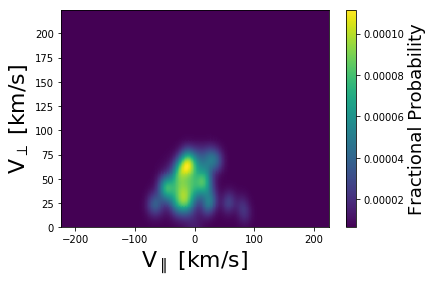

In [16]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

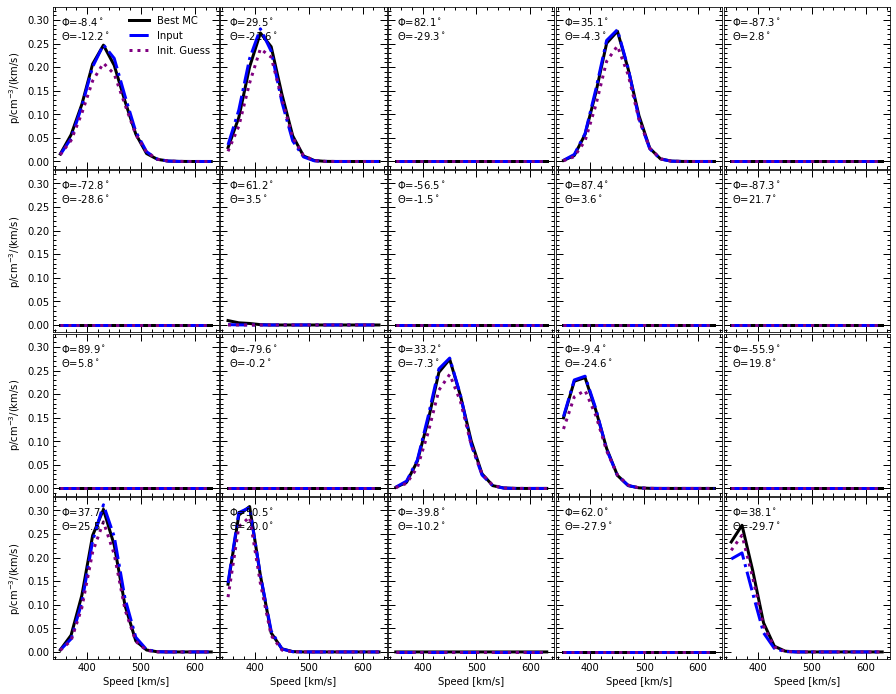

In [17]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

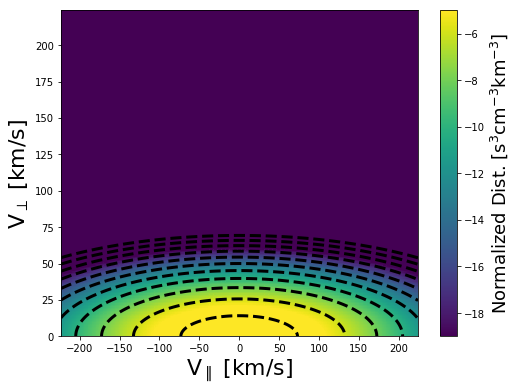

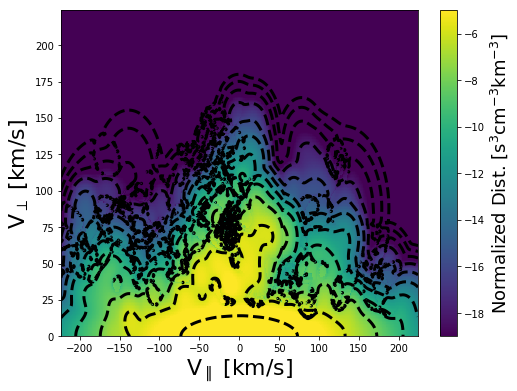

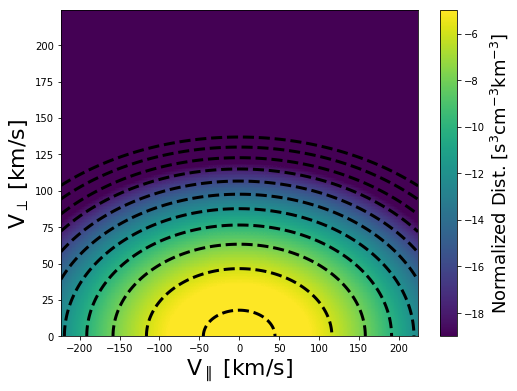

In [20]:
#Initial Guess from measurements
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()

In [19]:
reload(mdv)
reload(mff)

<module 'multi_fc_functions' from 'multi_fc_functions.pyc'>